In [2]:
import multiprocessing
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from fractions import Fraction
import time
import sys
from concurrent.futures import ProcessPoolExecutor
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from fractions import Fraction
import time



cores = multiprocessing.cpu_count()

T = 50
dt = 0.001
dyn_pendulum = {"g":9.81, "m": 1.0, "l": 1.0}
K = 10
delta0 = 1e-4
x0 = np.array([np.pi, 0.0])
I1 = np.array([1.0, 0.0])
I2 = np.array([0.0, 1.0])


def pendulum (x0, dyn):
    g = dyn['g'] 
    l = dyn['l']
    return np.array([x0[1], (-g/l)*np.sin(x0[0])])


def RungeKutta (dyn, f, dt, x0):
    k1 = f(x0, dyn) #[x,y,z]*0.1 example
    k2 = f(x0+0.5*k1*dt,dyn)
    k3 = f(x0 + 0.5*k2*dt, dyn)
    k4 = f(x0 + k3*dt, dyn)

    x = x0 + ((k1 + 2*k2 + 2*k3 + k4)/6) *dt
    return x


def f_t (dyn, f, dt, x0, T, K, delta0):
    x = np.empty(shape=(len(x0),T))
    xc1 = np.empty(shape=(len(x0),T))
    xc2 = np.empty(shape=(len(x0),T))
    x0c1 = x0 + I1*delta0
    x0c2 = x0 + I2*delta0
    le = np.array([0,0])
    for j in range(0,K):

        xc1[:, 0] = x0c1
        xc2[:, 0] = x0c2
        x[:, 0] = x0
        for i in range(1,T):
            x[:, i] = RungeKutta(dyn, f, dt, x[:, i-1])
            xc1[:, i] = RungeKutta(dyn, f, dt, xc1[:, i-1])
            xc2[:, i] = RungeKutta(dyn, f, dt, xc2[:, i-1])
        
        delta1x = x[:, -1] - xc1[:, -1]
        delta2x = x[:, -1] - xc2[:, -1]
#         print (delta1x)
        
        v1 = delta1x
        norm1 = np.linalg.norm(delta1x)
        u1 = delta1x/norm1

        GSC1 = np.dot(delta2x, u1)
        v2 = delta2x - GSC1*u1

        norm2 = np.linalg.norm(v2)
        u2 = v2/norm2

        
        x0c1 = x[:, -1]  + u1*delta0
        x0c2 = x[:, -1]  + u2*delta0
        x0 = x[:, -1] 
        
        le = le + np.log(np.array([norm1,norm2])/delta0)
#         print(norm1)

    
    return le/(K*T*dt)


In [55]:
le_sample = f_t (dyn_pendulum, pendulum, dt, x0, T, K, delta0)

In [56]:
le_sample

array([ 3.9872327, -3.9872327])

In [57]:
def cal_le (x):
    le = f_t (dyn_pendulum, pendulum, dt, x, T, K, delta0)
    return le

lx = np.linspace(0, 2*np.pi, 21)
ly = np.linspace(-8, 8, 21)
X = np.array(np.meshgrid(lx,ly))


X_reshaped = X.T.reshape(X.T.shape[0]*X.T.shape[1],2)
# X_reshaped = np.append(X_reshaped,np.array([[np.pi/2,0,0,0]]),axis=0)
# new_test_sin = np.array([np.sin(X_reshaped.T[0]),X_reshaped.T[1]])
le_list = []
points = list(X_reshaped)
# print ('I am here')
with ProcessPoolExecutor(max_workers=cores-1) as executor:
    for r in executor.map(cal_le, points, chunksize=10):
        # print (r)
        le_list.append(r)


zs = np.array(le_list)

np.save('precal_pendulum_cldyn_T50_K10_dt0001', zs)

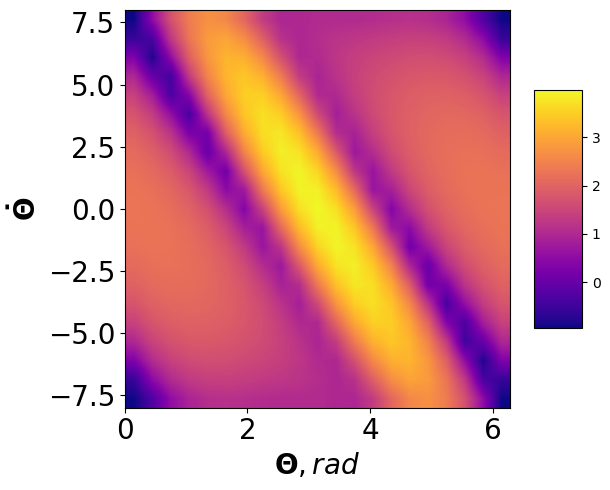

In [3]:
zs = np.load('precal_pendulum_cldyn_T50_K10_dt0001.npy')

T = 500
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

plot1 = ax.imshow(np.flip(zs[:,0].reshape(21,21),1).T, extent=[0,2*np.pi , -8,8],aspect='auto',cmap='plasma',interpolation="bilinear")
# ax.plot(tjt_fixed,tjt[1],linewidth=3, c='white')
cbar1 = fig.colorbar(plot1, shrink=0.6, aspect=5)
font = {'size': 20}
ax.tick_params('x', labelsize=font['size'])
ax.tick_params('y', labelsize=font['size'])
ax.set_ylabel(r"$\mathbf{\dot{\Theta}}$", fontsize = 20)
ax.set_xlabel(r"$\mathbf{\Theta},rad$", fontsize = 20)
# plt.title ('Simple Pendulum T=5s', fontsize = 20)


plt.tight_layout()
# fig.savefig('thesis_plots/pendulum-05.png', transparent=True)

In [ ]:
zs